In [1]:
import sys
from pathlib import Path
import os
import warnings
import time
import re
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
ANALYSIS_OUTPUT_ROOTDIR = os.getenv("ANALYSIS_OUTPUT_ROOTDIR")
DATA_ROOTDIR = os.getenv("DATA_ROOTDIR")
sys.path.append(SPIKECOUNTER_PATH)

import matplotlib.pyplot as plt
from matplotlib import patches, lines
from scipy import interpolate, signal, stats, optimize, ndimage
import scipy.io as scio
import numpy as np
import matplotlib.cm as cmaps
import matplotlib.colors as colors
import pickle
import seaborn as sbs
from parse import *
import matplotlib as mpl
import colorcet as cc
import seaborn as sns
from matplotlib import gridspec

from spikecounter.analysis import traces, images
from spikecounter import utils
from spikecounter.ui import visualize
from spikecounter.analysis import stats as sc_stats
from sklearn import neighbors
import lmfit
from cycler import cycler
import pandas as pd
import importlib
from statannotations.Annotator import Annotator

warnings.filterwarnings("once")
biopubs_style = os.path.join(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
plt.style.use(
    biopubs_style
)

In [2]:
rootdir = Path(ANALYSIS_OUTPUT_ROOTDIR, "2022 First Heartbeat_Submitted",
    "Figures/Data/Figure1")

expts = ["20210420_gcamp_widefield", \
         "20210716_gcamp_widefield", "20210724_gcamp_widefield"]
datadirs = [rootdir/d for d in expts]

In [3]:
output_datadir = Path(
    ANALYSIS_OUTPUT_ROOTDIR,
    "2022 First Heartbeat_Submitted",
    "Figures/Data/"
)

Montage dFFs

In [71]:
dFFs = []
offset_times = []
all_peaks = []
ts = []
total_embryos = 0
for datadir in datadirs:
    print(datadir)
    dFF_mat = scio.loadmat(os.path.join(datadir, "dFFs.mat"))
    print(dFF_mat.keys())
    print(dFF_mat['rois'])
    total_embryos += len(dFF_mat['rois'].ravel())
    offset_times.append(dFF_mat["offset_times"].ravel())
    all_peaks.append(pd.read_csv(os.path.join(datadir, "peaks_data.csv"), index_col="roi"))
    dFFs.append(dFF_mat['dFF'])
    ts.append(dFF_mat['t'].ravel())

/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210420_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]]
/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210716_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[0 1 2 3 4 5 6 7 8]]
/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210724_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17]]


In [72]:
all_peaks_combined = []
total_indices = 0
for ap in all_peaks:
    curr_index = ap.index.unique()
    reindex = dict([(curr, i+total_indices) for i, curr in enumerate(curr_index)])
    all_peaks_combined.append(ap.rename(index=reindex))
    total_indices += len(curr_index)
all_peaks_combined = pd.concat(all_peaks_combined, axis=0)

In [73]:
dFFs_ravelled = []
offset_times_ravelled = []
ts_ravelled = []
for i in range(len(datadirs)):
    dFF = dFFs[i]
    offset_time = offset_times[i].ravel()
    for j in range(dFF.shape[0]):
        dFFs_ravelled.append(dFF[j,:])
        offset_times_ravelled.append(offset_time[j])
        ts_ravelled.append(ts[i])

In [74]:
all_peaks_combined["offset_time"] = np.nan
for idx in all_peaks_combined.index.unique():
    all_peaks_combined.loc[idx, "offset_time"] = all_peaks_combined.loc[idx, "t"] - offset_times_ravelled[idx]
all_peaks_combined.loc[7, "offset_time"] = all_peaks_combined.loc[7, "t"] - all_peaks_combined.loc[7, "t"].iloc[0]
all_peaks_combined.loc[8, "offset_time"] = all_peaks_combined.loc[8, "t"] - all_peaks_combined.loc[8, "t"].iloc[0]
all_peaks_combined.loc[12, "offset_time"] = all_peaks_combined.loc[12, "t"] - all_peaks_combined.loc[12, "t"].iloc[0]
offset_times[0][7] = all_peaks_combined.loc[7, "t"].iloc[0]
offset_times[0][8] = all_peaks_combined.loc[8, "t"].iloc[0]
offset_times[0][12] = all_peaks_combined.loc[12, "t"].iloc[0]


$4\%$
$\Delta F/F$


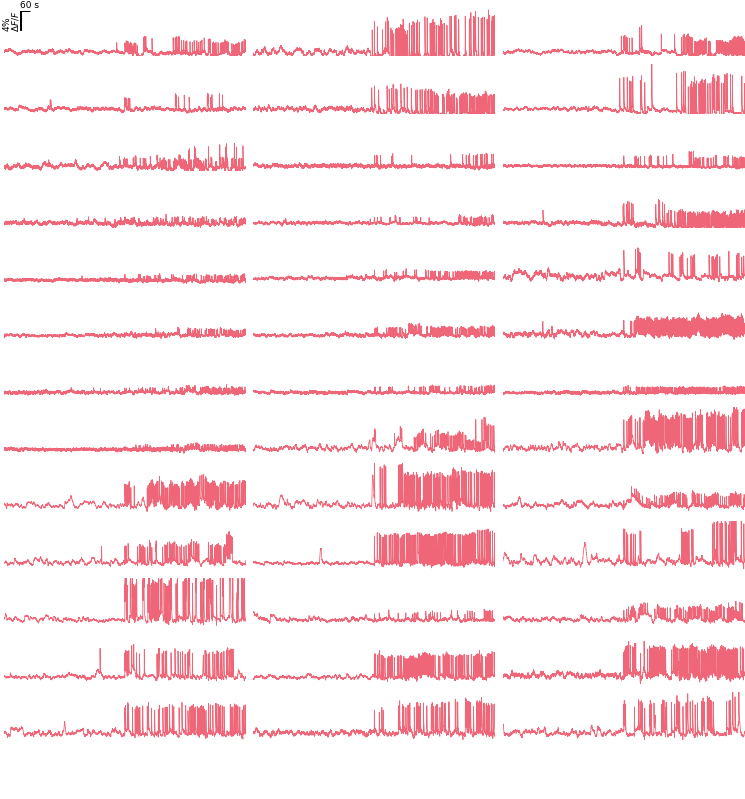

In [75]:
ncols = 3
nrows = total_embryos//ncols + 1

fig1, axes = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 0.8*nrows))
axes = axes.ravel()
half_window = 750

ecount = 0
dFFs_ravelled = []
offset_times_ravelled = []
for i in range(len(datadirs)):
    dFF = dFFs[i]
    times = ts[i]
    offset_time = offset_times[i].ravel()
    for j in range(dFF.shape[0]):
        axes[ecount].plot(times, dFF[j,:], color="C1")
        axes[ecount].set_xlim((offset_time[j] - half_window, offset_time[j] + half_window))
        axes[ecount].set_ylim((-0.01, 0.09))
        axes[ecount].set_axis_off()
        ecount += 1
        dFFs_ravelled.append(dFF[j,:])
        offset_times_ravelled.append(offset_time[j])
for i in range(ecount, nrows*ncols):
    axes[i].set_axis_off()
plt.tight_layout()
xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()

scalebar_params = {
    "corner_x": xlim[0]+100,
    "corner_y": ylim[1]*0.9,
    "ampl_scale": 0.04,
    "time_scale": 60,
    "fontsize": 9,
    "thickness": ylim[1]*0.02,
    "xlabel_offset_y": ylim[1]*0.1,
    "xlabel_offset_x": 0,
    "ylabel_offset_x": -120,
    "ylabel_offset_y": 0.005
    }
visualize.plot_scalebars(axes[0], scalebar_params, pct_f=True)
# os.makedirs(os.path.join(figdir, "Figure1/Supplements/"), exist_ok=True)
# plt.savefig(os.path.join(figdir, "Figure1/Supplements/", "all_first_heartbeats.svg"))

5.482254901962066e+03
4107.6470588244665
4145.686274510751
$4\%$
$\Delta F/F$


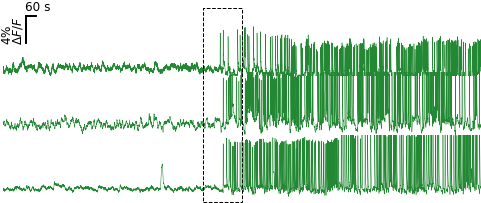

In [14]:
rep_traces = [4, 23, 28]

nrows = 3
ncols = 1
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    fig1, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 1*nrows))
    axes = axes.ravel()
    half_window = 1400
    ecount = 0
    for i in rep_traces:
        dFF = dFFs_ravelled[i]
        times = ts_ravelled[i]
        offset_time = offset_times_ravelled[i]
        print(offset_time)
#         if ecount == 2:
#             offset_time -=150
        axes[ecount].plot(times, dFF, linewidth=0.5, color="C2")
        axes[ecount].set_xlim((offset_time - half_window+200, offset_time + half_window))
        axes[ecount].set_ylim((-0.01, 0.07))
        axes[ecount].set_axis_off()
        ecount += 1
    for i in range(ecount, nrows*ncols):
        axes[i].set_axis_off()
    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.05)
    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()

    scalebar_params = {
        "corner_x": xlim[0] + 120,
        "corner_y": ylim[1]*0.9,
        "ampl_scale": ylim[1]*0.5,
        "time_scale": 60,
        "fontsize": 12,
        "thickness": ylim[1]*0.02,
        "xlabel_offset_y": ylim[1]*0.1,
        "xlabel_offset_x": 0,
        "ylabel_offset_x": -130,
        "ylabel_offset_y": 0.005
        }
    visualize.plot_scalebars(axes[0], scalebar_params, pct_f=True)
    offset_ref_loc = (half_window-200)/(2*half_window-200)
    zoom_half_window = 100
    start_x = offset_ref_loc - zoom_half_window/(2*half_window-200)
    width = 2*zoom_half_window/(2*half_window-200)
    rect = patches.Rectangle((start_x, 0.05), width, 0.9, fill=False, \
                             transform=fig1.transFigure, linestyle="--")
    fig1.patches.extend([rect])

5482.254901962066
4126.666666667608
4163.235294118598
$4\%$
$\Delta F/F$


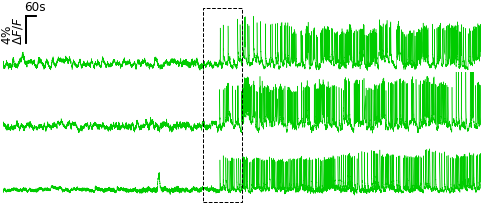

In [39]:
rep_traces = [4, 23, 28]

nrows = 3
ncols = 1
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    fig1, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 1*nrows))
    axes = axes.ravel()
    half_window = 1400
    ecount = 0
    for i in rep_traces:
        dFF = dFFs_ravelled[i]
        times = ts_ravelled[i]
        offset_time = offset_times_ravelled[i]
        print(offset_time)
#         if ecount == 2:
#             offset_time -=150
        axes[ecount].plot(times, dFF, linewidth=0.5, color="C2")
        axes[ecount].set_xlim((offset_time - half_window+200, offset_time + half_window))
        axes[ecount].set_ylim((-0.01, 0.07))
        axes[ecount].set_axis_off()
        ecount += 1
    for i in range(ecount, nrows*ncols):
        axes[i].set_axis_off()
    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.05)
    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()

    scalebar_params = {
        "corner_x": xlim[0] + 120,
        "corner_y": ylim[1]*0.9,
        "ampl_scale": ylim[1]*0.5,
        "time_scale": 60,
        "fontsize": 12,
        "thickness": ylim[1]*0.02,
        "xlabel_offset_y": ylim[1]*0.1,
        "xlabel_offset_x": 0,
        "ylabel_offset_x": -130,
        "ylabel_offset_y": 0.005
        }
    visualize.plot_scalebars(axes[0], scalebar_params, pct_f=True)
    offset_ref_loc = (half_window-200)/(2*half_window-200)
    zoom_half_window = 100
    start_x = offset_ref_loc - zoom_half_window/(2*half_window-200)
    width = 2*zoom_half_window/(2*half_window-200)
    rect = patches.Rectangle((start_x, 0.05), width, 0.9, fill=False, \
                             transform=fig1.transFigure, linestyle="--")
    fig1.patches.extend([rect])
    plt.savefig(os.path.join(figdir,"Figure1/POSTER_montage_representative.svg"))

$4\%$
$\Delta F/F$


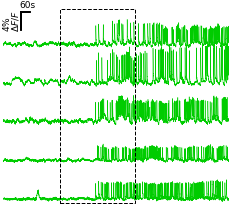

In [27]:
rep_traces = [4, 1, 23, 34, 28]

nrows = 5
ncols = 1
fig1, axes = plt.subplots(nrows, ncols, figsize=(3.4*ncols, 0.6*nrows))
axes = axes.ravel()
half_window = 750

ecount = 0
for i in rep_traces:
    dFF = dFFs_ravelled[i]
    times = ts_ravelled[i]
    offset_time = offset_times_ravelled[i]
#     if ecount == 0:
#         offset_time -=150
    axes[ecount].plot(times, dFF, linewidth=0.5, color="C2")
    axes[ecount].set_xlim((offset_time - half_window+200, offset_time + half_window))
    axes[ecount].set_ylim((-0.01, 0.09))
    axes[ecount].set_axis_off()
    ecount += 1
for i in range(ecount, nrows*ncols):
    axes[i].set_axis_off()
plt.tight_layout()
xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()

scalebar_params = {
    "corner_x": xlim[0]+95,
    "corner_y": ylim[1]*0.9,
    "ampl_scale": ylim[1]*0.5,
    "time_scale": 60,
    "fontsize": 9,
    "thickness": ylim[1]*0.02,
    "xlabel_offset_y": ylim[1]*0.11,
    "xlabel_offset_x": 0,
    "ylabel_offset_x": -110,
    "ylabel_offset_y": 0.005
    }
plt.subplots_adjust(hspace=-0.1)
visualize.plot_scalebars(axes[0], scalebar_params, pct_f=True)
offset_ref_loc = (half_window-200)/(2*half_window-200)
zoom_half_window = 200
start_x = offset_ref_loc - zoom_half_window/(2*half_window-200)
width = 2*zoom_half_window/(2*half_window-200)
rect = patches.Rectangle((start_x, 0.05), width, 0.9, fill=False, \
                         transform=fig1.transFigure, linestyle="--")
fig1.patches.extend([rect])

plt.savefig(os.path.join(figdir,"Figure1/montage_representative.svg"))

$5\%$
$\Delta F/F$


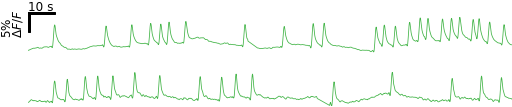

In [37]:
rep_traces = [23, 35]

nrows = 2
ncols = 1
with plt.style.context(biopubs_style):
    fig1, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 0.8*nrows))
    axes = axes.ravel()
    half_window = 90

    ecount = 0
    for i in rep_traces:
        dFF = dFFs_ravelled[i]
        times = ts_ravelled[i]
        offset_time = offset_times_ravelled[i]
        axes[ecount].plot(times, dFF, color="#44B549")
        axes[ecount].set_xlim((offset_time-10, offset_time + half_window*2-10))
#         axes[ecount].axvline(offset_time, color="k")
        axes[ecount].set_ylim((-0.01, 0.1))
        axes[ecount].set_axis_off()
        ecount += 1
    for i in range(ecount, nrows*ncols):
        axes[i].set_axis_off()
    plt.tight_layout()

    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()

    scalebar_params = {
        "corner_x": xlim[0],
        "corner_y": ylim[1]*0.9,
        "ampl_scale": ylim[1]*0.5,
        "time_scale": 10,
        "fontsize": 12,
        "thickness": ylim[1]*0.05,
        "xlabel_offset_y": ylim[1]*0.11,
        "xlabel_offset_x": 0,
        "ylabel_offset_x": -10,
        "ylabel_offset_y": 0
        }
    visualize.plot_scalebars(axes[0], scalebar_params, pct_f=True)
plt.savefig(output_datadir/"Figure2"/"model_expt_trace_comparison.svg")

In [16]:
cs = [np.array([0,204,0,255])/255, np.array([121,67,142,255])/255]


Text(-0.03, 0.25, 'Rel. intensity')

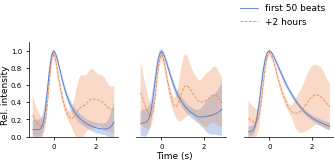

In [32]:
rep_traces = [4,23,28]
half_window = 100
sta_n_before = 10
sta_n_after = 30
n_sta = 50

fig1, axes = plt.subplots(1, 3, figsize=(4.5,1.5))

for idx, rt in enumerate(rep_traces):
    dFF = dFFs_ravelled[rt]
    offset_time = offset_times_ravelled[rt]
#     fig1, ax1 = plt.subplots(figsize=(8,4))
    times = ts_ravelled[rt]
    
    pks = all_peaks_combined.loc[rt]["peak_idx"]
    
    thresh_idx_1 = np.argwhere(times > offset_time).ravel()[0]
    thresh_idx_2 = np.argwhere(times > offset_time + 7200).ravel()[0]
    first_pks = pks[pks>thresh_idx_1][:n_sta]
    later_pks = pks[pks>thresh_idx_2][:n_sta]
    sta, ststd = traces.get_sta(dFF, first_pks, sta_n_before, sta_n_after, return_std=True)
    later_sta, later_ststd = traces.get_sta(dFF, later_pks, sta_n_before, sta_n_after, return_std=True)
    sta_t = (np.arange(len(sta)) - sta_n_before)/f_s
    axes[idx].plot(sta_t, sta, label="first 50 beats")
    axes[idx].fill_between(sta_t, sta-ststd, sta+ststd, alpha=0.3)
    axes[idx].plot(sta_t, later_sta, "--", label="+2 hours")
    axes[idx].fill_between(sta_t, later_sta-later_ststd, later_sta+later_ststd, alpha=0.3)

    axes[idx].set_ylim(0, 1.1)
    plt.tight_layout(pad=0.05)

axes[1].yaxis.set_visible(False)
axes[2].yaxis.set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[2].spines['left'].set_visible(False)
axes[2].legend(bbox_to_anchor=(1, 1.5))
fig1.text(0.45, -0.08, "Time (s)")
fig1.text(-0.03, 0.25, "Rel. intensity", rotation=90)

# plt.tight_layout(pad=0.5)
# plt.savefig("../all_widefield_data_new/representative_stas.svg")

In [63]:
all_peaks_combined.loc[8]

,peak_idx,prominence,fwhm,isi,t,hpf,offset_time,peak_group
roi,,,,,,,,
8,60048,0.017120,1.211126,68.725490,6247.058824,20.735294,5049.607843,60
8,60749,0.015999,1.160286,7.058824,6315.784314,20.754385,5118.333333,60
8,60821,0.017179,1.097637,6.078431,6322.843137,20.756345,5125.392157,60
8,60883,0.008969,2.366589,8.333333,6328.921569,20.758034,5131.470588,60
8,60968,0.017907,0.972697,13.039216,6337.254902,20.760349,5139.803922,60
...,...,...,...,...,...,...,...,...
8,190674,0.007141,0.600377,5.882353,19053.529412,24.292647,17856.078431,
8,190734,0.006055,1.867183,31.568627,19059.411765,24.294281,17861.960784,
8,191056,0.007031,0.402295,1.078431,19090.980392,24.303050,17893.529412,


In [76]:
compare_offset = 3600
n_sta = 50
all_peaks_combined["peak_group"] = ""
for idx in all_peaks_combined.index.unique():
    first_idx = np.argwhere(all_peaks_combined.loc[idx, "offset_time"].values >= 0).ravel()[0]
    later_idx = np.argwhere(all_peaks_combined.loc[idx, "offset_time"].values >= compare_offset).ravel()[0]
    all_peaks_combined.loc[idx, "peak_group"].iloc[first_idx:first_idx+n_sta] = "0"
    all_peaks_combined.loc[idx, "peak_group"].iloc[later_idx:later_idx+n_sta] = "60"
peaks_of_interest = all_peaks_combined[(all_peaks_combined["peak_group"]=="0") |\
                                       (all_peaks_combined["peak_group"]=="60")].set_index("peak_group", append=True)
peaks_of_interest["norm_peak_amplitude"] = np.nan
for roi in peaks_of_interest.index.unique("roi"):
    peaks_of_interest.loc[roi, "norm_peak_amplitude"] =\
    peaks_of_interest.loc[roi, "prominence"].values/np.max(\
                                peaks_of_interest.loc[(roi, "0"), "prominence"].values)
#         peaks_of_interest.loc[roi, "prominence"].values/np.nanpercentile(\
#                                 peaks_of_interest.loc[(roi, "0"), "prominence"].values, 100)
            
embryo_mean_values = peaks_of_interest.groupby(level=["roi", "peak_group"]).mean().reset_index().set_index("roi")

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 60: t-test paired samples, P_val:3.615e-07 t=-6.144e+00


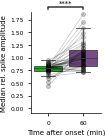

In [80]:
x="peak_group"
y="norm_peak_amplitude"
fig1, ax1 = plt.subplots(figsize=(2*0.8,3*0.7))
order  = ["0", "60"]
# arr1 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# arr2 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# ax1.boxplot([arr1, arr2])

grouped_means = embryo_mean_values.reset_index().set_index("peak_group")

cs = [np.array([0,204,0,255])/255, np.array([121,67,142,255])/255]
sns.boxplot(data=embryo_mean_values, x=x, y=y,ax=ax1, order=["0", "60"], palette=cs, fliersize=0)
ax1.set_ylim(-0.1, 1.9)
ax1.set_xlabel("Time after onset (min)")
ax1.set_ylabel(r"Median rel. spike amplitude")

ax1.scatter(0*np.ones(grouped_means.loc["0"].shape[0]), grouped_means.loc["0"][y],\
            alpha=0.2, color="k", s=16)
ax1.scatter(1*np.ones(grouped_means.loc["60"].shape[0]), grouped_means.loc["60"][y],\
            alpha=0.2, color="k", s=16)
ax1.plot(np.array([0*np.ones(grouped_means.loc["0"].shape[0]), 1*np.ones(grouped_means.loc["60"].shape[0])]), \
    np.array([grouped_means.loc["0"][y].values,  grouped_means.loc["60"][y].values]),\
    color="k", alpha=0.2)

pairs = [("0", "60")]
# for patch, color in zip(bplot['boxes'], cs):
#     patch.set_facecolor(color)

annot = Annotator(ax1, pairs, data=embryo_mean_values, x=x,y=y)
annot.configure(test="t-test_paired", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 60: t-test paired samples, P_val:1.159e-11 t=9.565e+00


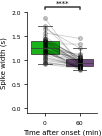

In [79]:
x="peak_group"
y="fwhm"
fig1, ax1 = plt.subplots(figsize=(2*0.8,3*0.7))
order  = ["0", "60"]
# arr1 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# arr2 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# ax1.boxplot([arr1, arr2])

grouped_means = embryo_mean_values.reset_index().set_index("peak_group")

cs = [np.array([0,204,0,255])/255, np.array([121,67,142,255])/255]
sns.boxplot(data=embryo_mean_values, x=x, y=y,ax=ax1, order=["0", "60"], palette=cs, fliersize=0)
ax1.set_ylim(-0.1, 2)
ax1.set_xlabel("Time after onset (min)")
ax1.set_ylabel(r"Mean spike width (s)")

ax1.scatter(0*np.ones(grouped_means.loc["0"].shape[0]), grouped_means.loc["0"][y],\
            alpha=0.2, color="k", s=16)
ax1.scatter(1*np.ones(grouped_means.loc["60"].shape[0]), grouped_means.loc["60"][y],\
            alpha=0.2, color="k", s=16)
ax1.plot(np.array([0*np.ones(grouped_means.loc["0"].shape[0]), 1*np.ones(grouped_means.loc["60"].shape[0])]), \
    np.array([grouped_means.loc["0"][y].values,  grouped_means.loc["60"][y].values]),\
    color="k", alpha=0.2)

pairs = [("0", "60")]
# for patch, color in zip(bplot['boxes'], cs):
#     patch.set_facecolor(color)

annot = Annotator(ax1, pairs, data=embryo_mean_values, x=x,y=y)
annot.configure(test="t-test_paired", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 60: t-test paired samples, P_val:6.420e-12 t=9.774e+00


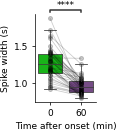

In [138]:
x="peak_group"
y="fwhm"
fig1, ax1 = plt.subplots(figsize=(2*0.8,3*0.7))
order  = ["0", "60"]
# arr1 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# arr2 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# ax1.boxplot([arr1, arr2])

grouped_means = embryo_mean_values.reset_index().set_index("peak_group")

cs = [np.array([0,204,0,255])/255, np.array([121,67,142,255])/255]
sns.boxplot(data=embryo_mean_values, x=x, y=y,ax=ax1, order=["0", "60"], palette=cs, fliersize=0)
# ax1.set_ylim(-0.1, 2)
ax1.set_xlabel("Time after onset (min)")
ax1.set_ylabel(r"Spike width (s)")

ax1.scatter(0*np.ones(grouped_means.loc["0"].shape[0]), grouped_means.loc["0"][y],\
            alpha=0.2, color="k", s=16)
ax1.scatter(1*np.ones(grouped_means.loc["60"].shape[0]), grouped_means.loc["60"][y],\
            alpha=0.2, color="k", s=16)
ax1.plot(np.array([0*np.ones(grouped_means.loc["0"].shape[0]), 1*np.ones(grouped_means.loc["60"].shape[0])]), \
    np.array([grouped_means.loc["0"][y].values,  grouped_means.loc["60"][y].values]),\
    color="k", alpha=0.2)

pairs = [("0", "60")]
# for patch, color in zip(bplot['boxes'], cs):
#     patch.set_facecolor(color)

annot = Annotator(ax1, pairs, data=embryo_mean_values, x=x,y=y)
annot.configure(test="t-test_paired", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()

In [17]:
half_window = 100
sta_n_before = 10
sta_n_after = 30
n_sta = 50

$4\%$
$\Delta F/F$


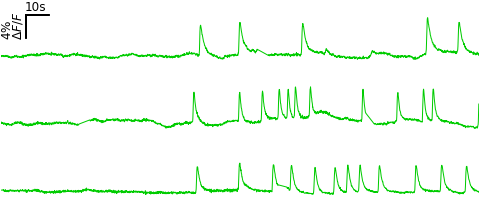

In [40]:
rep_traces = [4, 23, 28]

nrows = 3
ncols = 1
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    fig1, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 1*nrows))
    axes = axes.ravel()

    ecount = 0
    for i in rep_traces:
        dFF = dFFs_ravelled[i]
        times = ts_ravelled[i]
        offset_time = offset_times_ravelled[i]
#         if ecount == 0:
#             offset_time -=150
        axes[ecount].plot(times, dFF, color="C2")
        axes[ecount].set_xlim((offset_time - zoom_half_window, offset_time + zoom_half_window))
        axes[ecount].set_ylim((-0.01, 0.07))
        axes[ecount].set_axis_off()
        ecount += 1
    for i in range(ecount, nrows*ncols):
        axes[i].set_axis_off()
    plt.tight_layout()

    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()

    scalebar_params = {
        "corner_x": xlim[0]+10,
        "corner_y": ylim[1]*0.9,
        "ampl_scale": ylim[1]*0.5,
        "time_scale": 10,
        "fontsize": 12,
        "thickness": ylim[1]*0.02,
        "xlabel_offset_y": ylim[1]*0.1,
        "xlabel_offset_x": 0,
        "ylabel_offset_x": -10,
        "ylabel_offset_y": 0.005
        }
    visualize.plot_scalebars(axes[0], scalebar_params, pct_f=True)
    plt.savefig(os.path.join(figdir, "Figure1/POSTER_montage_representative_zoom.svg"))

$4\%$
$\Delta F/F$


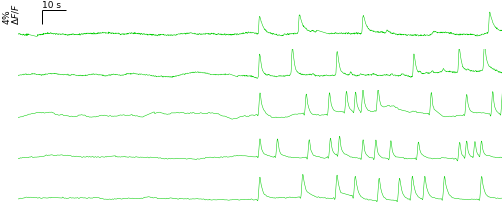

In [15]:
rep_traces = [4, 1, 23, 34, 28]
zoom_half_window = 100
nrows = 5
ncols = 1
fig1, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 0.6*nrows))
axes = axes.ravel()

ecount = 0
for i in rep_traces:
    dFF = dFFs_ravelled[i]
    times = ts_ravelled[i]
    offset_time = offset_times_ravelled[i]
    axes[ecount].plot(times, dFF, linewidth=0.5, color="C2")
    axes[ecount].set_xlim((offset_time - zoom_half_window, offset_time + zoom_half_window))
    axes[ecount].set_ylim((-0.01, 0.07))
    axes[ecount].set_axis_off()
    ecount += 1
for i in range(ecount, nrows*ncols):
    axes[i].set_axis_off()
plt.tight_layout()

xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()

scalebar_params = {
    "corner_x": xlim[0]+10,
    "corner_y": ylim[1]*0.9,
    "ampl_scale": ylim[1]*0.5,
    "time_scale": 10,
    "fontsize": 9,
    "thickness": ylim[1]*0.02,
    "xlabel_offset_y": ylim[1]*0.12,
    "xlabel_offset_x": 0,
    "ylabel_offset_x": -17,
    "ylabel_offset_y": 0.007
    }
visualize.plot_scalebars(axes[0], scalebar_params, pct_f=True)
# plt.savefig(os.path.join(figdir, "Figure1/montage_representative_zoom.svg"))

### Calculate and fit amplitudes

In [9]:
# colormap #54d3cc to #539ad4

cmatrix = np.zeros((3,5,3))
cmatrix[:,:,0] = np.arange(cmatrix.shape[1])/(cmatrix.shape[1]-1)
# cmatrix[:,0,1:3] = np.array([84,211,204])[:,None]/255
# cmatrix[:,0,1:3] = np.array([140,234,231])[:,None]/255

# cmatrix[:,1,1:3] = np.array([83,154,212])[:,None]/255

cmatrix[:,0,1:3] = np.array((15,94,156))[:,None]/255
cmatrix[:,1,1:3] = np.array((35,137,218))[:,None]/255
cmatrix[:,2,1:3] = np.array((28,163,236))[:,None]/255
cmatrix[:,3,1:3] = np.array((90,188,216))[:,None]/255
cmatrix[:,4,1:3] = np.array((116,204,244))[:,None]/255

# cmatrix[:,4,1:3] = np.array([179,205,224])[:,None]/255


cdict = {'red':   cmatrix[0].tolist(),
         'green': cmatrix[1].tolist(),
         'blue':  cmatrix[2].tolist()}

newcmp = colors.LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

In [10]:
def sigmoid(x, tau, x0, a):
    return a/(1 + np.exp(-(x - x0)/tau))

[ 1.62769646 -0.62457371  1.00673571]
4.821581066864607e-02


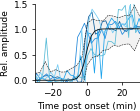

In [11]:
xs = []
ys = []
seed = 426535
np.random.seed(seed)
fig1, ax1 = plt.subplots(figsize=(2.2,1.8))
n_traces = 5
traces_to_plot = np.random.choice(np.arange(len(dFFs_ravelled)), size=n_traces, replace=False)
stride = 1200
p0 = 10
p1 = 63

counter = 0
for idx, dFF in enumerate(dFFs_ravelled):

    max_intensity = ndimage.maximum_filter1d(dFF, stride, mode="nearest")

    y0 = np.percentile(max_intensity, p0)
    y1 = np.percentile(max_intensity, p1)
    norm_max_intensity = (max_intensity - y0)/(y1-y0)
    t = ts_ravelled[idx] - offset_times_ravelled[idx]
    t = t[::stride]/60
    norm_max_intensity = norm_max_intensity[::stride]
    if idx in traces_to_plot:
        ax1.plot(t, norm_max_intensity, color=newcmp(counter/4))
        counter += 1
    xs.append(t.ravel())
    ys.append(norm_max_intensity.ravel())

xs = np.concatenate(xs)
ys = np.concatenate(ys)
popt, _ = optimize.curve_fit(sigmoid, xs, ys)
print(popt)
chisq = np.sum((ys-sigmoid(xs, popt[0],popt[1],popt[2]))**2)/len(xs)
print(chisq)
x_fit = np.linspace(np.min(xs), np.max(xs), 200)
y_fit = sigmoid(x_fit, popt[0], popt[1],popt[2])
ax1.plot(x_fit, y_fit, color="k")

ax1.set_xlabel("Time post onset (min)")
ax1.set_ylabel("Rel. amplitude")
ax1.set_ylim((-0.03, 1.5))
ax1.set_xlim((-30, 30))

bin_size = 3
x_ticks = np.arange(np.min(xs), np.max(xs), step=bin_size)
nearest_bin = np.argmin(np.subtract.outer(xs, x_ticks)**2, axis=1)
x_binned = x_ticks[nearest_bin]

mean_value = []
std_value = []
for x in x_ticks:
    binned_values = ys[x_binned==x]
    mean_value.append(np.mean(binned_values))
    std_value.append(np.std(binned_values))
mean_value = np.array(mean_value)
std_value = np.array(std_value)
ax1.fill_between(x_ticks, mean_value-std_value, mean_value+std_value, color="k", alpha=0.05, lw=0, edgecolor=None)
ax1.plot(x_ticks, mean_value-std_value,color="k", lw=0.5, linestyle="--")
ax1.plot(x_ticks, mean_value+std_value,color="k", lw=0.5, linestyle="--")


plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure2/amplitude_transition.svg"))

### Analyze statistics of temporal dynamics

Plot histograms of interspike intervals for individual traces.

IndexError: index 36 is out of bounds for axis 0 with size 36

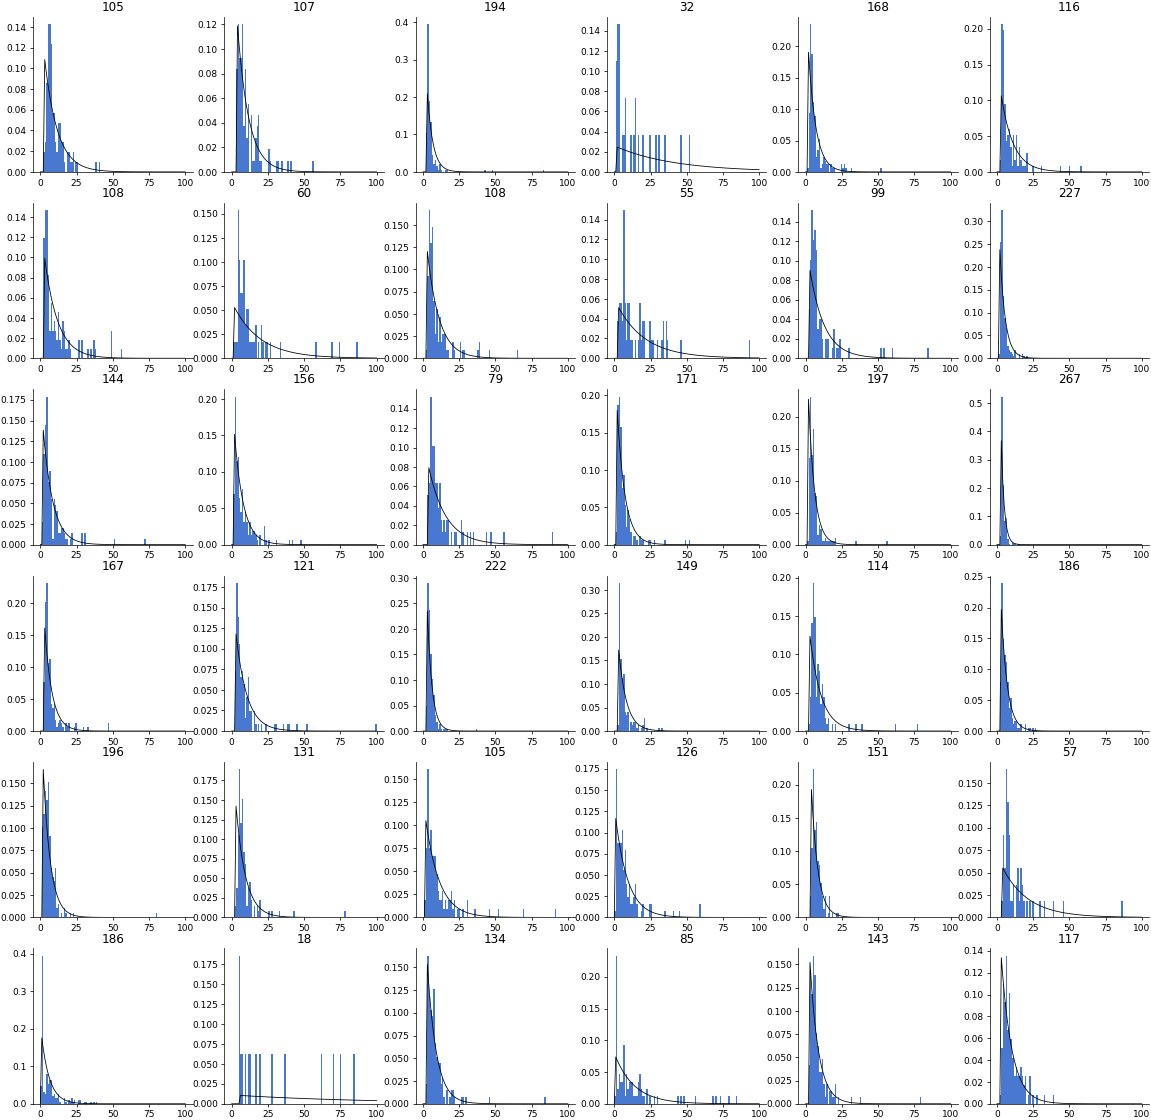

In [74]:
plt.close("all")
duration = 1200
fig1, axes = plt.subplots(6,6,figsize=(20, 20))
axes = axes.ravel()
for i in range(len(offset_times_ravelled)):
    offset_time = offset_times_ravelled[i]
#     print(offset_time)
    peak_data = all_peaks_combined.loc[i]
    x = np.linspace(0, 100, 100)
    pks = peak_data[(peak_data["t"] >= offset_time)&(peak_data["t"] < offset_time+duration)]
    params = stats.expon.fit(pks["isi"])
    rv = stats.expon(params[0], params[1])
    y = rv.pdf(x)
    axes[i].hist(pks["isi"], density=True, bins = x)
    axes[i].plot(x,y, color="k")
    axes[i].set_title(pks.shape[0])

Plot at different time windows

In [200]:
# colormap #d89ded to #79438e

cmatrix = np.zeros((3,2,3))
cmatrix[:,1,0] = 1
cmatrix[:,0,1:3] = np.array([216,157,237])[:,None]/255
cmatrix[:,1,1:3] = np.array([121,67,142])[:,None]/255

cdict = {'red':   cmatrix[0].tolist(),
         'green': cmatrix[1].tolist(),
         'blue':  cmatrix[2].tolist()}

newcmp = colors.LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

In [35]:
cs = ["C2", "#539ad4", "#79438e"]

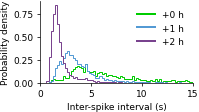

In [41]:
plt.close("all")
duration = 600
shifts = [0,3600,7200]
fig1, ax1 = plt.subplots(figsize=(3, 1.8))
combined_isi = []
combined_isi_shifted = []
x = np.linspace(0, 100, 500)
custom_lines = []
custom_labels = []
for j, shift in enumerate(shifts):
    combined_isi_shifted = []
    for i in range(len(offset_times_ravelled)):
        offset_time = offset_times_ravelled[i]
        peak_data = all_peaks_combined.loc[i]
        pks = peak_data[(peak_data["t"] >= offset_time+shift)&(peak_data["t"] < offset_time+duration+shift)]
        combined_isi_shifted.extend(list(pks["isi"]))
    ax1.hist(combined_isi_shifted, density=True, bins = x, \
             histtype="step", color=cs[j])
    custom_labels.append("+%d h" %(shift/3600))
    custom_lines.append(lines.Line2D([0], [0], color=cs[j], lw=2))
# ax1.plot(x,y, color="k")
ax1.set_xlim(0,15)
ax1.set_xlabel("Inter-spike interval (s)")
ax1.set_ylabel("Probability density")
ax1.legend(custom_lines, custom_labels)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure2","isi_histogram.svg"))

In [5]:
expt_moments = []
for datadir in datadirs:
    expt_moments.append(scio.loadmat(os.path.join(datadir, "all_moments.mat")))

Align all frequencies and CVs from different experiments

In [10]:
unaligned_frequencies = []
unaligned_covs = []
all_index_offsets = []
for i in range(len(expt_moments)):
    moments = expt_moments[i]
    unaligned_frequencies.append(moments["all_freqs"])
    unaligned_covs.append(moments["covs"])
    all_index_offsets.append(moments["idx_offsets"].ravel())
dt = moments["hpf"].ravel()[1]-moments["hpf"].ravel()[0]
aligned_frequencies, global_time_freq = utils.align_traces(unaligned_frequencies, all_index_offsets)
aligned_covs, _ = utils.align_traces(unaligned_covs, all_index_offsets)
time_rel_offset = global_time_freq*dt

Plot individual frequency moments

(140000.0, 142000.0)

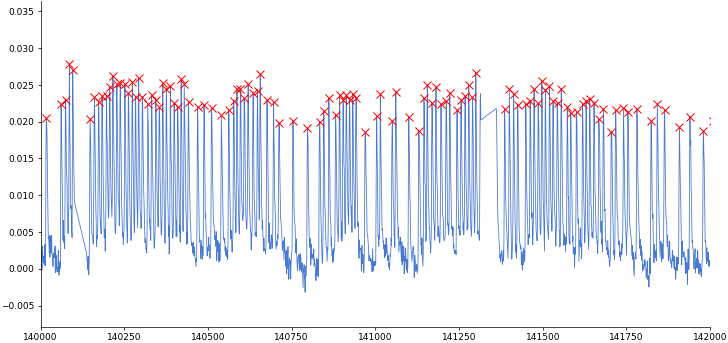

In [79]:
idx = 38
start = 140000
window = 2000
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(dFFs_ravelled[idx])
pks = all_peaks_combined.loc[idx]["peak_idx"]
ax1.plot(pks, dFFs_ravelled[idx][pks], "rx")
ax1.set_xlim(start, start+window)

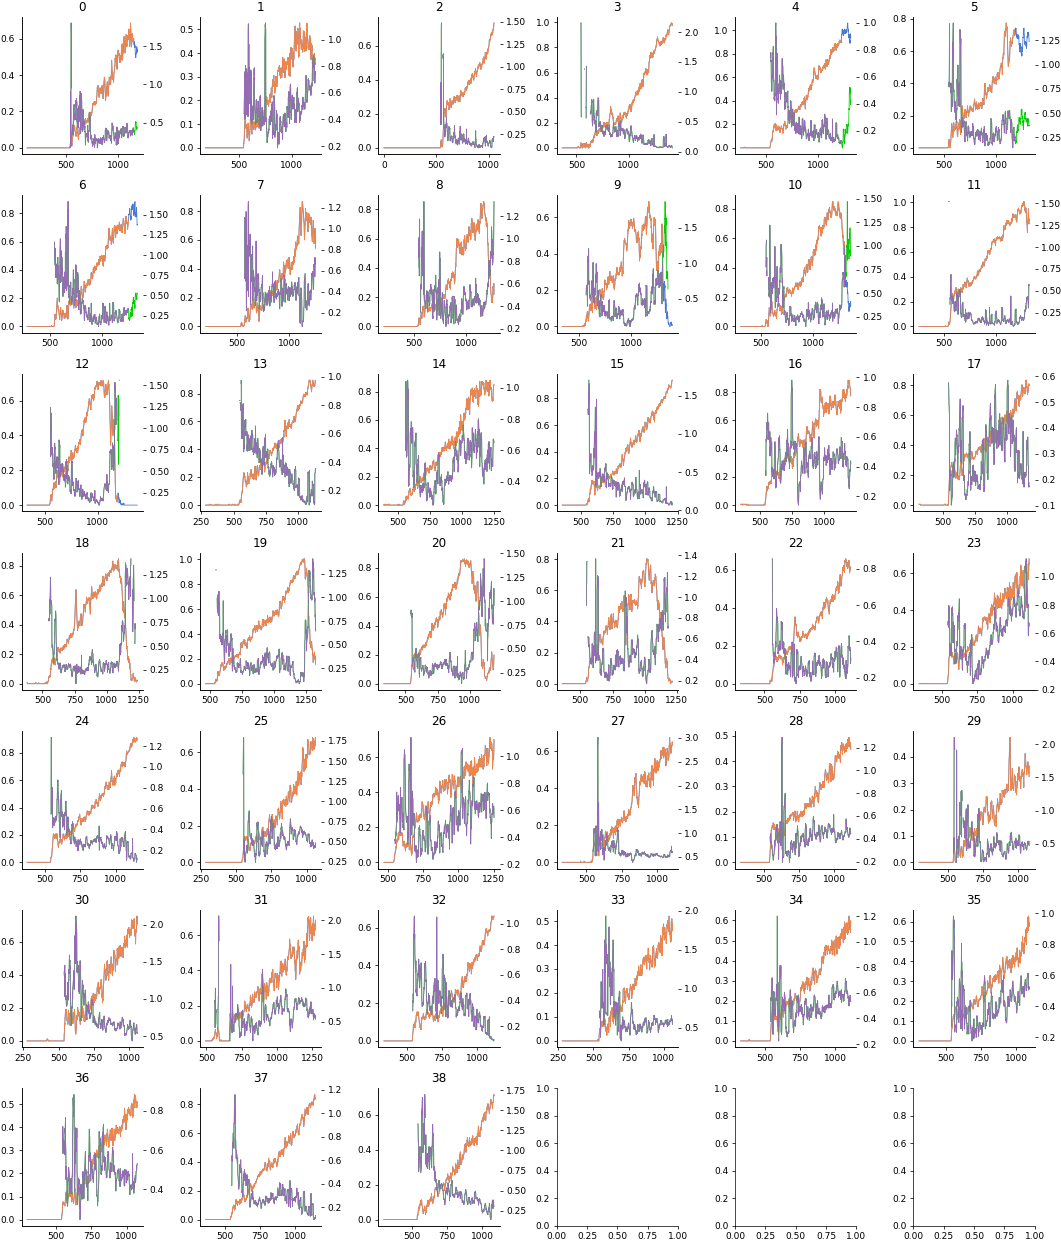

In [11]:
index_cutoffs = np.ones(aligned_covs.shape[0], dtype=int)*aligned_covs.shape[1]
index_cutoffs[0] = 1150
index_cutoffs[4] = 1220
index_cutoffs[5] = 1180
index_cutoffs[6] = 1250
index_cutoffs[9] = 1300
index_cutoffs[10] = 1300
index_cutoffs[11] = 1350
index_cutoffs[12] = 1190

fig1, axes = visualize.tile_plots_conditions(np.arange(aligned_covs.shape[0]), (2.5,2.5))
for i in range(aligned_covs.shape[0]):
    axes[i].set_title("%d" % i)
    axes[i].plot(aligned_frequencies[i,:])
    axes[i].plot(aligned_frequencies[i,:index_cutoffs[i]])
    ax2 = axes[i].twinx()
    ax2.plot(aligned_covs[i,:], color="C2")
    ax2.plot(aligned_covs[i,:index_cutoffs[i]], color="C4")
plt.tight_layout()

In [12]:
for i in range(aligned_frequencies.shape[0]):
    if index_cutoffs[i] < aligned_frequencies.shape[1]:
        aligned_frequencies[i,index_cutoffs[i]:] = np.nan
        aligned_covs[i,index_cutoffs[i]:] = np.nan

Plot summary plots

In [13]:
np.random.seed(2134)
sample_traces = np.random.choice(aligned_frequencies.shape[0], size=5, replace=False)

In [93]:
# colormap #54d3cc to #539ad4

cmatrix = np.zeros((3,5,3))
cmatrix[:,:,0] = np.arange(cmatrix.shape[1])/(cmatrix.shape[1]-1)
# cmatrix[:,0,1:3] = np.array([84,211,204])[:,None]/255
# cmatrix[:,0,1:3] = np.array([140,234,231])[:,None]/255

# cmatrix[:,1,1:3] = np.array([83,154,212])[:,None]/255

cmatrix[:,0,1:3] = np.array((15,94,156))[:,None]/255
cmatrix[:,1,1:3] = np.array((35,137,218))[:,None]/255
cmatrix[:,2,1:3] = np.array((28,163,236))[:,None]/255
cmatrix[:,3,1:3] = np.array((90,188,216))[:,None]/255
cmatrix[:,4,1:3] = np.array((116,204,244))[:,None]/255

# cmatrix[:,4,1:3] = np.array([179,205,224])[:,None]/255


cdict = {'red':   cmatrix[0].tolist(),
         'green': cmatrix[1].tolist(),
         'blue':  cmatrix[2].tolist()}

newcmp = colors.LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

In [16]:
newcmp = visualize.tol_vibrant()

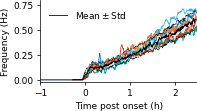

In [18]:
fig1, ax1 = plt.subplots(figsize=(3, 1.8))
# ax1.plot(time_rel_offset_freq, aligned_frequencies.T, alpha=0.2)
q1, q2, q3 = np.percentile(aligned_frequencies, (25, 50, 75), axis=0)
for j in range(len(sample_traces)):
    ax1.plot(time_rel_offset, aligned_frequencies[sample_traces[j]], alpha=1, color=newcmp(j))
ax1.plot(time_rel_offset, q2, color="k", label=r"$\mathrm{Mean} \pm \mathrm{Std}$")
ax1.fill_between(time_rel_offset, q1, q3, color="k", alpha=0.1, lw=0, edgecolor=None)
ax1.plot(time_rel_offset, q1,color="k", lw=0.5, linestyle="--")
ax1.plot(time_rel_offset, q3,color="k", lw=0.5, linestyle="--")

ax1.set_xlim(-1, 2.5)
ax1.set_ylim(-0.02, 0.8)
ax1.set_xlabel("Time post onset (h)")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_yticks([0, 0.25, 0.5, 0.75])
ax1.legend()
plt.tight_layout()
# plt.savefig(os.path.join(figdir, "Figure2", "aligned_frequencies.svg"))

In [25]:
pop_quartiles = pd.DataFrame(np.array([time_rel_offset, q1, q2, q3]).T, columns=["time_post_offset_h", "p25", "p50", "p75"])
pop_quartiles.to_csv(os.path.join(output_datadir, "Figure1", "population_frequency.csv"))

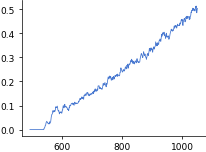

In [23]:
output_dat

/tmp/ipykernel_172510/1777045544.py:4: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


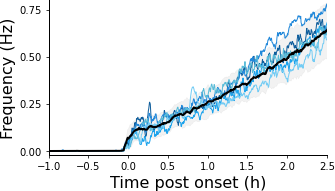

In [94]:
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    fig1, ax1 = plt.subplots(figsize=(5,3))
    # ax1.plot(time_rel_offset_freq, aligned_frequencies.T, alpha=0.2)
    mean_freq = np.nanmean(aligned_frequencies, axis=0)
    std_freq = np.nanstd(aligned_frequencies, axis=0)
    
    for j in range(len(sample_traces)):
        ax1.plot(time_rel_offset, aligned_frequencies[sample_traces[j]], alpha=1, color=newcmp(j/4))
    ax1.plot(time_rel_offset, mean_freq, color="k", label=r"$\mathrm{Mean} \pm \mathrm{Std}$",linewidth=2)
    ax1.fill_between(time_rel_offset, mean_freq-std_freq, mean_freq+std_freq, color="k", alpha=0.05, lw=0.5, edgecolor="black")
    
    ax1.set_xlim(-1, 2.5)
    ax1.set_ylim(-0.02, 0.8)
    ax1.set_xlabel("Time post onset (h)")
    ax1.set_ylabel("Frequency (Hz)")
    ax1.set_yticks([0, 0.25, 0.5, 0.75])
    # ax1.legend()
    plt.tight_layout()
#     plt.savefig(os.path.join(figdir, "Figure2/Presentations", "aligned_frequencies.svg"))

In [105]:
aligned_frequencies.shape

(39, 1603)

In [107]:
start_idx = np.argwhere(time_rel_offset > 0.5).ravel()[0]
x = time_rel_offset[start_idx:]
y = aligned_frequencies[:,start_idx:]
x = np.tile(x, y.shape[0]).ravel()
y = y.ravel()
nanmask = np.isnan(y)
x = x[~nanmask]
y = y[~nanmask]
res = stats.linregress(x, y)
print("Std Err slope(/min): ", res.stderr*60)
print("Fit slope (/min): ", res.slope*60)

/tmp/ipykernel_268231/4256852116.py:3: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


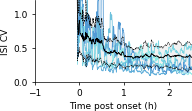

In [165]:
fig1, ax1 = plt.subplots(figsize=(3,1.8))
# ax1.plot(time_rel_offset_cov, aligned_covs.T, alpha=0.2)
mean_cov = np.nanmean(aligned_covs, axis=0)
std_cov = np.nanstd(aligned_covs, axis=0)
std_freq = np.nanstd(aligned_frequencies, axis=0)
for j in range(len(sample_traces)):
    ax1.plot(time_rel_offset, aligned_covs[sample_traces[j]], \
             alpha=1, color=newcmp(j/4))
ax1.plot(time_rel_offset, mean_cov, color="k", label=r"$\mathrm{Mean} \pm \mathrm{Std}$")
ax1.fill_between(time_rel_offset, mean_cov-std_cov, mean_cov+std_cov, color="k", alpha=0.05, lw=0, edgecolor=None)
ax1.plot(time_rel_offset, mean_cov-std_cov,color="k", lw=0.5, linestyle="--")
ax1.plot(time_rel_offset, mean_cov+std_cov,color="k", lw=0.5, linestyle="--")
ax1.set_xlim(-1, 2.5)
ax1.set_ylim(0,1.2)
ax1.set_xlabel("Time post onset (h)")
ax1.set_ylabel("ISI CV")
# ax1.legend()
plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure2", "aligned_covs.svg"))

/tmp/ipykernel_23263/1919310967.py:4: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


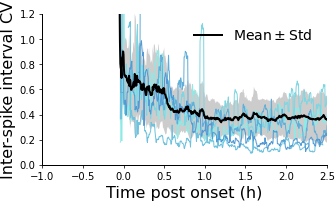

In [38]:
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    fig1, ax1 = plt.subplots(figsize=(5,3))
    # ax1.plot(time_rel_offset_cov, aligned_covs.T, alpha=0.2)
    mean_cov = np.nanmean(aligned_covs, axis=0)
    std_cov = np.nanstd(aligned_covs, axis=0)
    for j in range(len(sample_traces)):
        ax1.plot(time_rel_offset, aligned_covs[j], alpha=1, color=newcmp(j/4))
    ax1.plot(time_rel_offset, mean_cov, color="k", label=r"$\mathrm{Mean} \pm \mathrm{Std}$", lw=2)
    ax1.fill_between(time_rel_offset, mean_cov-std_cov, mean_cov+std_cov, color="k", alpha=0.2, lw=0, edgecolor=None)
    ax1.set_xlim(-1, 2.5)
    ax1.set_ylim(0,1.2)
    ax1.set_xlabel("Time post onset (h)")
    ax1.set_ylabel("Inter-spike interval CV")
    ax1.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "Figure2/Presentations", "aligned_covs.svg"))

/tmp/ipykernel_100169/4083833047.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_100169/4083833047.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_100169/4083833047.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=d

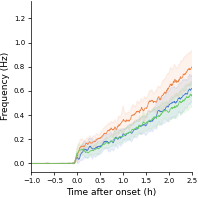

In [161]:
fig1, ax1 = plt.subplots(figsize=(3,3))
for i in range(3):
    moments = expt_moments[i]
    aligned_frequencies = moments["all_freqs_aligned"]
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    mean_freq = np.nanmean(aligned_frequencies, axis=0)
    std_freq = np.nanstd(aligned_frequencies, axis=0)
    x = (np.arange(len(mean_freq)) - np.max(all_offsets))*(hpf[1]-hpf[0])
    ax1.plot(x, mean_freq, color="C%d" % i)
    ax1.fill_between(x, mean_freq-std_freq, mean_freq+std_freq, alpha=0.1, color="C%d" %i)

    ax1.set_xlabel("Time after onset (h)")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlim(-1, 2.5)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "../../Supplementary Figures/widefield_frequency_batch_effect.svg"))

/tmp/ipykernel_100169/327353070.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_100169/327353070.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_100169/327353070.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


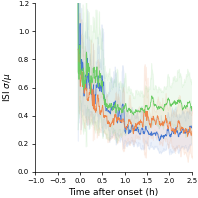

In [163]:
fig1, ax1 = plt.subplots(figsize=(3,3))
for i in range(3):
    moments = expt_moments[i]   
    aligned_covs = moments["covs_aligned"]
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    mean_cov = np.nanmean(aligned_covs, axis=0)
    std_cov = np.nanstd(aligned_covs, axis=0)
    x = (np.arange(len(mean_cov)) - np.max(all_offsets))*(hpf[1]-hpf[0])
    ax1.plot(x, mean_cov, color="C%d" % i)
    ax1.fill_between(x, mean_cov-std_cov, mean_cov+std_cov, alpha=0.1, color="C%d" %i)

    ax1.set_xlabel("Time after onset (h)")
ax1.set_ylim(0,1.2)
ax1.set_xlim(-1, 2.5)
ax1.set_ylabel(r"ISI $\sigma/\mu$")
plt.tight_layout()
plt.savefig(os.path.join(figdir, "../../Supplementary Figures/widefield_cov_batch_effect.svg"))

Plot distribution of start times

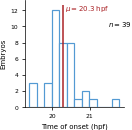

In [52]:
hpf_starts = []
for moments in expt_moments:
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    hpf_starts.extend(hpf[all_offsets].tolist()[0])
hpf_starts[7] = all_peaks_combined.loc[7, "hpf"].iloc[0]
mean_hpf = np.mean(hpf_starts)
fig1, ax1 = plt.subplots(figsize=(2,2))
ax1.hist(hpf_starts, linewidth=1.2, bins=12, edgecolor="#539ad3", facecolor="white")
ymin, ymax = ax1.get_ylim()
ax1.vlines(mean_hpf, ymin=ymin, ymax=ymax, linewidth=1.5, color="#A91F23")
ax1.text(mean_hpf+0.05, ymax*0.95, r"$\mu = %.1f\ \mathrm{hpf}$" % mean_hpf, color="#A91F23")
ax1.text(21.5, 10, r"$n = %d$" % len(hpf_starts))
ax1.set_xlabel("Time of onset (hpf)")
ax1.set_ylabel("Embryos")
plt.tight_layout()
plt.savefig(os.path.join(rootdir, "beat_start_histo.svg"))

In [199]:
np.std(hpf_starts)

0.4150610354434058

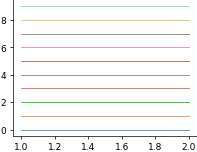

In [85]:
q = np.linspace(1, 2, 100)
for a in range(10):
    plt.plot(q, a*np.ones_like(q))

### Fit to LIF model

In [68]:
sim_datadir = "/n/holyscratch01/cohen_lab/bjia/20210503_LIF_sims"

# sim_datadir = "/n/cohen_lab/Lab/Labmembers/Bill Jia/Data/Simulations/20210503_LIF_sims"
simulation_results = np.load(os.path.join(sim_datadir, "results.npz"))

In [60]:
sigmas = set([])
rs = set([])
for f in os.listdir(sim_datadir):
    res = parse("sigma_{sigma:f}_r_{r:f}.mat", f)
    if res is not None:
        sigmas.add(res['sigma'])
        rs.add(res['r'])
sigmas = np.sort(np.array(list(sigmas)))
rs = np.sort(np.array(list(rs)))

In [65]:
isi_mu = np.zeros((len(sigmas),len(rs)))
isi_std = np.zeros((len(sigmas),len(rs)))
freq = np.zeros((len(sigmas),len(rs)))
power_spectra = np.zeros(( len(sigmas),len(rs),4096))

In [66]:
for file in os.listdir(sim_datadir):
    res = parse("sigma_{sigma:f}_r_{r:f}.mat", file)
    if res is not None:
        matres = scio.loadmat(os.path.join(sim_datadir, file))
        row = np.argwhere(sigmas==res['sigma'])[0][0]
        col = np.argwhere(rs==res['r'])[0][0]
        isi_mu[row, col] = matres['isi_mu'][0][0]
        isi_std[row, col] = matres['isi_std'][0][0]
        freq[row, col] = matres['f'][0][0]
        power_spectra[row, col, :] = matres['ps'].ravel()

In [67]:
np.savez(os.path.join(sim_datadir, "results.npz"), isi_cv=isi_std/isi_mu, freq=freq, sigmas=sigmas, rs=rs)

In [69]:
cov_sim = simulation_results["isi_cv"]
f_sim = simulation_results["freq"]
sigmas = simulation_results["sigmas"]
rs = simulation_results["rs"]

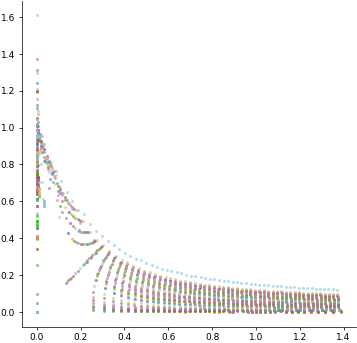

In [70]:
fig1, ax1 = plt.subplots(figsize=(6,6))
for row in range(len(sigmas)):
    ax1.scatter(f_sim[row,:], cov_sim[row,:], alpha=0.5, s=4)

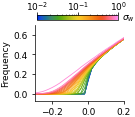

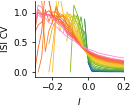

In [71]:
cmap = plt.get_cmap("cet_CET_R1")
offset = -1
fig1, ax1 = plt.subplots(figsize=(1.6, 1.4))
fig2, ax2 = plt.subplots(figsize=(1.6, 1.4))
for row in range(len(sigmas)):
    ax1.plot(rs+offset, f_sim[row,:], c=cmap((row+0.05)/(len(sigmas)+0.05)))
    ax2.plot(rs+offset, cov_sim[row,:], c=cmap((row+0.05)/(len(sigmas)+0.05)))

ax1.set_xlim(0.7+offset, 1.2+offset)
ax2.set_xlim(0.7+offset, 1.2+offset)
ax2.set_ylim(None, 1.2)
ax1.set_ylim(None, 0.7)
ax1.set_ylabel("Frequency")
ax2.set_ylabel(r"ISI CV")
ax2.set_xlabel(r"$I$")
plt.figure(fig1.number)
cax = plt.axes([0.15, 0.93, 0.7, 0.05])
plt.colorbar(cmaps.ScalarMappable(norm=colors.LogNorm(vmin=np.min(sigmas), \
                                                   vmax=np.max(sigmas)), cmap="cet_CET_R1"), cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.tick_params(axis='x', pad=-1)
fig1.text(0.88, 0.93, r"$\sigma_w$")
# plt.tight_layout()
plt.figure(fig1.number)
# plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure5", "frequency_sim_family.tif"), dpi=300)
plt.figure(fig2.number)
# plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure5", "cv_sim_family.svg"))

In [13]:
np.linspace(0, 2, num=31)

array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
       1.        , 1.06666667, 1.13333333, 1.2       , 1.26666667,
       1.33333333, 1.4       , 1.46666667, 1.53333333, 1.6       ,
       1.66666667, 1.73333333, 1.8       , 1.86666667, 1.93333333,
       2.        ])

In [72]:
freq_mats = []
cov_mats = []
for i in range(3):
    moments = expt_moments[i]
    freq_mats.append(moments["all_freqs"])
    cov_mats.append(moments["covs"])

n_embryos = [fm.shape[0] for fm in freq_mats]
n_embryos_cumulative = np.cumsum([0] + n_embryos)
max_duration_freq = np.max([fm.shape[1] for fm in freq_mats])
max_duration_cov = np.max([cm.shape[1] for cm in cov_mats])

all_expt_freqs = np.nan*np.ones((n_embryos_cumulative[-1], max_duration_freq))
ecov = np.nan*np.ones((n_embryos_cumulative[-1], max_duration_cov))
for i in range(len(freq_mats)):
    fm = freq_mats[i]
    cm = cov_mats[i]
    all_expt_freqs[n_embryos_cumulative[i]:n_embryos_cumulative[i+1],:fm.shape[1]] = fm
    ecov[n_embryos_cumulative[i]:n_embryos_cumulative[i+1], :cm.shape[1]] = cm

In [73]:
n_valid = np.sum(~np.isnan(aligned_frequencies), axis=1)
characteristic_scale = 0.3/(np.mean(n_valid))
print(characteristic_scale)
x0_factor = 1000
x2_factor = 10

0.00034365270516360216


In [74]:
def gen_fitfun_single_param(row, relweight=1):
    ### Here covdata and fdata are Nx2 arrays of the experimental data
    frequency = f_sim[row,:]
    cov = cov_sim[row,:]
    ccov = sc_stats.correct_cov(cov, rs)
    f_lookup = interpolate.interp1d(rs, frequency, fill_value="extrapolate")
    cov_lookup = interpolate.interp1d(rs, ccov, fill_value="extrapolate")

    def fit_function(params, x=None, dat1=None, dat2=None):
        freq_valid = ~np.isnan(dat1)
        cov_valid = ~np.isnan(dat2)
        x_valid_freq = x[freq_valid]
        x_valid_cov = x[cov_valid]
        model1 = f_lookup(params['x_scale']/x0_factor*(x_valid_freq-540) + params['x_offset']/x2_factor+1)
        model2 = cov_lookup(params['x_scale']/x0_factor*(x_valid_cov-540) + params['x_offset']/x2_factor+1)
        resid1 = (params['amplitude']*dat1[freq_valid] - model1)
        resid2 = (dat2[cov_valid] - model2)*relweight
        return np.concatenate((resid1, resid2))
    return fit_function, f_lookup, cov_lookup

(-0.01, 0.4)

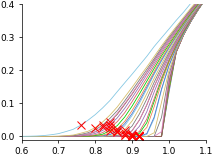

In [77]:
f_sim_smoothed = signal.savgol_filter(f_sim, 15, 2, axis=1)
max_diff = np.argmax(np.gradient(np.gradient(f_sim_smoothed, axis=1), axis=1), axis=1)
plt.plot(rs, f_sim.T)
for i in range(f_sim.shape[0]):
    plt.plot(rs[max_diff[i]], f_sim[i,max_diff[i]], "rx")

plt.xlim(0.6, 1.1)
plt.ylim(-0.01, 0.4)

In [78]:
rs[max_diff]

array([0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.9 , 0.9 , 0.9 ,
       0.9 , 0.9 , 0.9 , 0.9 , 0.88, 0.88, 0.88, 0.88, 0.86, 0.86, 0.86,
       0.84, 0.84, 0.84, 0.84, 0.82, 0.82, 0.8 , 0.76])

In [79]:
#including nans
scale_factors = [1000,1,10]
n_embryos = aligned_frequencies.shape[0]
xvals_data = np.arange(aligned_frequencies.shape[1])
err_nm = np.zeros((n_embryos, len(sigmas)))
beta_nm = np.zeros((n_embryos, len(sigmas), 3))
flookup_nm = np.zeros(len(sigmas), dtype=object)
covlookup_nm = np.zeros(len(sigmas), dtype=object)
bounds = np.nan*np.ones((n_embryos, len(sigmas), 3, 2))
for row in range(len(sigmas)):
    fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
                                                       540, -1, scale_factors, relweight=1)
    flookup_nm[row] = f_lookup
    covlookup_nm[row] = cov_lookup
    for embryo in range(n_embryos):
        f_expt = aligned_frequencies[embryo,:]
        cov_expt = aligned_covs[embryo,:]
        bounds_embryo = np.array([[characteristic_scale*0.5*scale_factors[0], characteristic_scale*1.5*scale_factors[0]], \
          [0.65, 0.9], \
          [((rs[max_diff[row]]-1)-0.1)*scale_factors[2], (rs[max_diff[row]]-0.98)*scale_factors[2]]])
        bounds[embryo,row,:,:] = bounds_embryo
        params = lmfit.Parameters()
        params.add('x_scale', value=characteristic_scale*x0_factor,\
                   min=bounds_embryo[0,0], max=bounds_embryo[0,1])
        params.add('amplitude', value=1.5, min=bounds_embryo[1,0], max=bounds_embryo[1,1])
        params.add('x_offset', value=(bounds_embryo[2,0]+bounds_embryo[2,1])/2,\
                   min=bounds_embryo[2,0], max=bounds_embryo[2,1])
        out = lmfit.minimize(fitfun, params, args=(xvals_data, f_expt, cov_expt),\
                                 max_nfev=3000, method="ampgo")
        err_nm[embryo, row] = out.redchi
        beta_nm[embryo, row, :] = [out.params['x_scale'].value, out.params['amplitude'].value, out.params['x_offset'].value]
# np.savez(os.path.join("../all_widefield_data/individual_fits.npz"), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)

In [19]:
fit_params = np.load(os.path.join("../all_widefield_data/individual_fits.npz"))
beta_nm = fit_params['beta_nm']
bounds =  fit_params['bounds']

Get least squares error for each embryo on each fit

In [81]:
lstsq = np.ones(beta_nm.shape[:2])*np.nan
# for sigma_idx in [0]:
for sigma_idx in range(f_sim.shape[0]):
    frequency = f_sim[sigma_idx]
    cov = cov_sim[sigma_idx]
    interp_f = interpolate.interp1d(rs, frequency)
    interp_cov = interpolate.interp1d(rs, cov)
    
    xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/x0_factor*beta_nm[:,sigma_idx,0][:,np.newaxis] +\
                beta_nm[:,sigma_idx,2][:,np.newaxis]/x2_factor + 1
    y1_expt = beta_nm[:,sigma_idx,1][:,None]*aligned_frequencies
    y1_sim = interp_f(xvals_data_scaled)
    sqdiff1 = (y1_expt-y1_sim)**2
    n_samples1 = (~np.isnan(sqdiff1)).astype(int).sum(axis=1)
    
    y2_expt = aligned_covs
    y2_sim = interp_cov(xvals_data_scaled)
    sqdiff2 = (y2_expt-y2_sim)**2
    n_samples2 = (~np.isnan(sqdiff2)).astype(int).sum(axis=1)
    
    lstsq[:, sigma_idx] = np.nansum(sqdiff1+sqdiff2, axis=1)/(n_samples1+n_samples2)
np.savez(os.path.join(sim_datadir, "individual_fits.npz"), err_nm=lstsq, beta_nm=beta_nm, bounds=bounds)

In [82]:
median_lstsq = np.nanmedian(lstsq, axis=0)
mean_lstsq = np.nanmean(lstsq, axis=0)

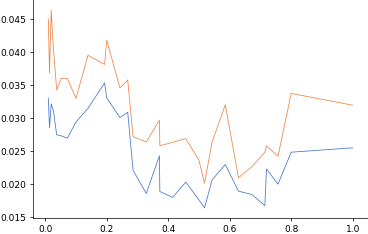

In [83]:
fig1, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(sigmas, median_lstsq)
ax1.plot(sigmas, mean_lstsq)

In [84]:
np.argmin(median_lstsq)

20

In [85]:
sigmas[20]

0.517947

[ 0.44570688  0.65673581 -1.63217755]
[[ 0.17182635  0.51547906]
 [ 0.65        0.9       ]
 [-2.4        -1.2       ]]
[ 0.18046575  0.65007863 -1.20000988]
[[ 0.17182635  0.51547906]
 [ 0.65        0.9       ]
 [-2.4        -1.2       ]]
[ 0.49390183  0.65023553 -1.4172497 ]
[[ 0.17182635  0.51547906]
 [ 0.65        0.9       ]
 [-2.4        -1.2       ]]
[ 0.51547906  0.65000001 -1.20000001]
[[ 0.17182635  0.51547906]
 [ 0.65        0.9       ]
 [-2.4        -1.2       ]]
[ 0.51216847  0.66339319 -1.20205797]
[[ 0.17182635  0.51547906]
 [ 0.65        0.9       ]
 [-2.4        -1.2       ]]


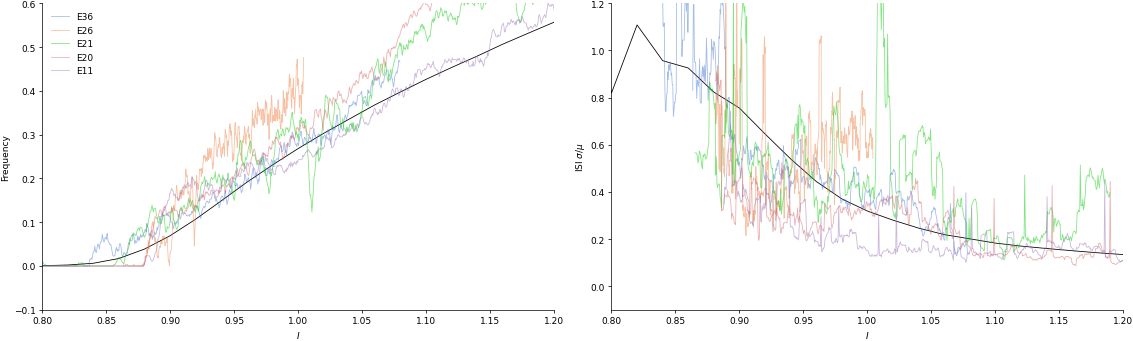

In [86]:
fig1, axes = plt.subplots(1, 2, figsize=(16,5))
axes = axes.ravel()
row = 20
frequency = f_sim[row,:]
cov = cov_sim[row,:]
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/x0_factor*beta_nm[:,row,0][:,np.newaxis] +\
                beta_nm[:,row,2][:,np.newaxis]/x2_factor + 1

axes[0].plot(rs, frequency, color="black")
axes[1].plot(rs, cov, color="black")

sorted_indices = np.random.choice(aligned_frequencies.shape[0], size=5, replace=False)
for e in sorted_indices:
    print(beta_nm[e,row,:])
    print(bounds[e,row,:,:])
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1], alpha=0.5, label="E%d" % e)
    axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
axes[0].legend()
axes[0].set_xlabel(r"$I$")
axes[1].set_xlabel(r"$I$")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel(r"ISI $\sigma/\mu$")
axes[0].set_xlim((0.8,1.2))
axes[1].set_xlim((0.8,1.2))
axes[0].set_ylim((-0.1,0.6))

axes[1].set_ylim((-0.1, 1.2))
plt.tight_layout()

In [87]:
fitted_f_interpolation_functions = []
fitted_cv_interpolation_functions = []
for e in range(aligned_frequencies.shape[0]):
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    
    xdat_f = xvals_data_scaled[e,~np.isnan(f_expt)]
    xdat_cov = xvals_data_scaled[e,~np.isnan(cov_expt)]
    f_expt_masked = f_expt[~np.isnan(f_expt)]
    cov_expt_masked = cov_expt[~np.isnan(cov_expt)]
    
    fitted_f_interpolation_functions.append(interpolate.interp1d(xdat_f, f_expt_masked*beta_nm[e,row,1],\
                                                fill_value=(f_expt_masked[0]*beta_nm[e,row,1], f_expt_masked[-1]*beta_nm[e,row,1]), bounds_error=False))
    fitted_cv_interpolation_functions.append(interpolate.interp1d(xdat_cov, cov_expt_masked,\
                                                fill_value=(cov_expt_masked[0], cov_expt_masked[-1]), bounds_error=False))

data_disp_range = np.linspace(0.8, 1.1, num=100)
all_xs = np.tile(data_disp_range, beta_nm.shape[0])
all_interp_fs = np.array([f(data_disp_range) for f in fitted_f_interpolation_functions])
all_interp_cvs = np.array([f(data_disp_range) for f in fitted_cv_interpolation_functions])

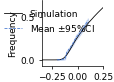

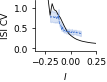

In [89]:
fig1, ax1 = plt.subplots(figsize=(1.6,1.4))
fig2, ax2 = plt.subplots(figsize=(1.6,1.4))

axes = [ax1, ax2]
display_offset = 1

axes[0].plot(rs-display_offset, frequency, color="black", label="Simulation")
axes[1].plot(rs-display_offset, cov, color="black")
axes[0].set_xlim(-0.35, 0.25)
axes[1].set_xlim(-0.35, 0.25)

sbs.lineplot(x=all_xs.ravel()-display_offset,\
             y=all_interp_fs.ravel(), ax=axes[0])
axes[0].lines[1].set_linestyle("--")
axes[0].lines[1].set_label(r"Mean $\pm 95\% \mathrm{CI}$")
axes[0].legend()
axes[0].set_ylabel("Frequency")
axes[0].set_ylim(None, 0.7)

sbs.lineplot(x=all_xs.ravel()-1, \
             y=all_interp_cvs.ravel(), ax=axes[1])


axes[1].lines[1].set_linestyle("--")
axes[1].set_ylim(None, 1.2)
axes[1].set_ylabel(r"ISI CV")
axes[1].set_xlabel(r"$I$")
axes[1].set_yticks([0, 0.5, 1])
plt.figure(fig1)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure5/mean_freq_fitting_v2.svg"))
plt.figure(fig2)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure5/cv_fitting_v2.svg"))

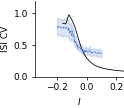

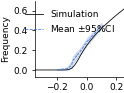

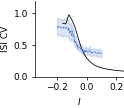

In [22]:
fig1, ax1 = plt.subplots(figsize=(1.6,1.4))
fig2, ax2 = plt.subplots(figsize=(1.6,1.4))

axes = [ax1, ax2]
display_offset = 1

axes[0].plot(rs-display_offset, frequency, color="black", label="Simulation")
axes[1].plot(rs-display_offset, cov, color="black")
axes[0].set_xlim(-0.35, 0.25)
axes[1].set_xlim(-0.35, 0.25)

sbs.lineplot(x=all_xs.ravel()-display_offset,\
             y=all_interp_fs.ravel(), ax=axes[0])
axes[0].lines[1].set_linestyle("--")
axes[0].lines[1].set_label(r"Mean $\pm 95\% \mathrm{CI}$")
axes[0].legend()
axes[0].set_ylabel("Frequency")
axes[0].set_ylim(None, 0.7)

sbs.lineplot(x=all_xs.ravel()-1, \
             y=all_interp_cvs.ravel(), ax=axes[1])


axes[1].lines[1].set_linestyle("--")
axes[1].set_ylim(None, 1.2)
axes[1].set_ylabel(r"ISI CV")
axes[1].set_xlabel(r"$I$")
axes[1].set_yticks([0, 0.5, 1])
plt.figure(fig1)
# plt.tight_layout()
# plt.savefig(os.path.join(figdir, "Figure5/mean_freq_fitting.svg"))
plt.figure(fig2)
# plt.tight_layout()
# plt.savefig(os.path.join(figdir, "Figure5/cv_fitting.svg"))

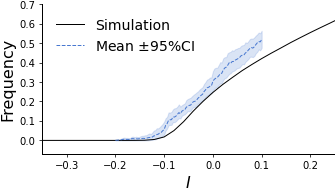

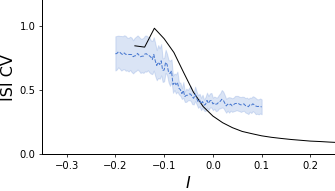

In [48]:
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    fig1, ax1 = plt.subplots(figsize=(5,3))
    fig2, ax2 = plt.subplots(figsize=(5,3))
    axes = [ax1, ax2]
    display_offset = 1

    axes[0].plot(rs-display_offset, frequency, color="black", label="Simulation")
    axes[1].plot(rs-display_offset, cov, color="black")
    axes[0].set_xlim(-0.35, 0.25)
    axes[1].set_xlim(-0.35, 0.25)

    sbs.lineplot(x=all_xs.ravel()-display_offset,\
                 y=all_interp_fs.ravel(), ax=axes[0])
    axes[0].lines[1].set_linestyle("--")
    axes[0].lines[1].set_label(r"Mean $\pm 95\% \mathrm{CI}$")
    axes[0].legend()
    axes[0].set_ylabel("Frequency")
    axes[0].set_ylim(None, 0.7)

    sbs.lineplot(x=all_xs.ravel()-1, \
                 y=all_interp_cvs.ravel(), ax=axes[1])


    axes[1].lines[1].set_linestyle("--")
    axes[1].set_ylim(None, 1.2)
    axes[1].set_ylabel(r"ISI CV")
    axes[0].set_xlabel(r"$I$")
    axes[1].set_xlabel(r"$I$")
    axes[1].set_yticks([0, 0.5, 1])
    plt.figure(fig1)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "Figure2/Presentations/mean_freq_fitting.svg"))
    plt.figure(fig2)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "Figure2/Presentations/cv_fitting.svg"))

### Spatial structure analysis

Analyze correlation of segmented trace to pixels over time.

In [6]:
corr_data_structs = []
for d in datadirs:
    with open(os.path.join(d, "correlation_data.pickle"), "rb") as f:
        corr_data_structs.append(pickle.load(f))

In [ ]:
def sigmoid(x, tau, x0, a):
    return a/(1 + np.exp(-(x - x0)/tau))

In [151]:
def custom_transition(x, x0, tau):
    y = np.heaviside(x-x0, 0)*(1-np.exp(-tau*(x-x0)))
    return y

In [152]:
def custom_transition2(x, tau):
    x0 = 0
    y = np.heaviside(x-x0, 0)*(1-np.exp(-(x-x0)/tau))
    return y

In [22]:
correlation_data.keys()

dict_keys(['overlay_images', 'correlations', 'traces', 't_offsets', 'segment_masks', 'correlated_size', 'mean_corr'])

In [35]:
corr_size

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 90,  0,  0])

In [40]:
corr_dfs = []
um_per_px = 9
for ci, correlation_data in enumerate(corr_data_structs):
    for roi in sorted(correlation_data["traces"].keys()):
        t_offsets = np.array(correlation_data["t_offsets"][roi])
        if "mean_corr" in correlation_data.keys():
            mean_corr = np.array(correlation_data["mean_corr"][roi])
            corr_size = np.array(correlation_data["correlated_size"][roi])
            mask = np.ones(len(t_offsets), dtype=bool)
            y = corr_size
            
            y[mean_corr < 0.65] = 0
            print(y)
        else:
            y = np.array(correlation_data["correlated_size_65"][roi])
            print(y)
        x = t_offsets/60
        y_norm = y/np.nanpercentile(y, 95)
        corr_dfs.append(pd.DataFrame({"expt": [datadirs[ci].name]*len(x),
                                      "embryo": [roi]*len(x),
                                    "time_post_onset_min": x,
                                      "corr_size_um2": y*um_per_px**2,
                                     "corr_size_rel": y_norm}))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 134 129 161
 155 153 154 154 149 143 151 146 149 156 135 183 192]
[  0   0   0   0   0   0   0 266 159 111   0   0   0   0   0 226 237 217
 234 225 233 226 218 229 225 231 212 222 213 222 202]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 303 221 242
 313 303   0 371 320 350 352 352 352 334 349 335 316]
[  0   0   0   0   0   0   0   0   0   0   0 124   0   0   0 186   0   0
 175 147 147   0 163 154 164   0 136 171 143 184 181]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 120 175 156
 165 183 180 192 190 200 194 189 182 208 198 188 199]
[  0   0   0   0   0   0   0   0   0   0  61   0   0   0   0 181 221 169
 214 258 268 243 294 281 304 285 300 278 297 298 271]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0  90 147 160 131
 154 132 128 150 181 178 170 175 158 188 180 171 179]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 142 144 154 155 194 189 165 1

/tmp/ipykernel_189482/2290014965.py:18: RuntimeWarning: divide by zero encountered in true_divide
  y_norm = y/np.nanpercentile(y, 95)
/tmp/ipykernel_189482/2290014965.py:18: RuntimeWarning: invalid value encountered in true_divide
  y_norm = y/np.nanpercentile(y, 95)


In [41]:
corr_dfs_combined = pd.concat(corr_dfs, axis=0)

In [43]:
corr_dfs_combined

,expt,embryo,time_post_onset_min,corr_size_um2,corr_size_rel
0,20210420_gcamp_widefield,0,-30.202288,0,0.00000
1,20210420_gcamp_widefield,0,-28.202288,0,0.00000
2,20210420_gcamp_widefield,0,-26.218954,0,0.00000
3,20210420_gcamp_widefield,0,-24.235621,0,0.00000
4,20210420_gcamp_widefield,0,-22.235621,0,0.00000
...,...,...,...,...,...
56,20210724_gcamp_widefield,16,51.486275,11664,0.90000
57,20210724_gcamp_widefield,16,53.469608,11907,0.91875
58,20210724_gcamp_widefield,16,55.469608,12069,0.93125
59,20210724_gcamp_widefield,16,57.452941,12312,0.95000


In [42]:
corr_dfs_combined.to_csv(output_datadir/"Figure2"/"correlated_active_area.csv")

/tmp/ipykernel_28579/2855136924.py:15: RuntimeWarning: divide by zero encountered in true_divide
  y = y/np.percentile(y, 95)
/tmp/ipykernel_28579/2855136924.py:15: RuntimeWarning: invalid value encountered in true_divide
  y = y/np.percentile(y, 95)


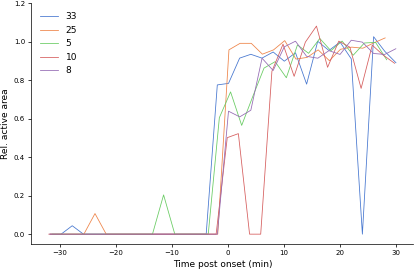

In [72]:
fig1, ax1 = plt.subplots(figsize=(6,4))
xs = []
ys = []
mean_corrs = []
for ci, correlation_data in enumerate(corr_data_structs):
    for roi in sorted(correlation_data["traces"].keys()):
        t_offsets = np.array(correlation_data["t_offsets"][roi])
        mean_corr = np.array(correlation_data["mean_corr"][roi])
        corr_size = np.array(correlation_data["correlated_size"][roi])
        mask = np.ones(len(t_offsets), dtype=bool)

        x = t_offsets/60
        y = corr_size
        y[mean_corr < 0.65] = 0
        y = y/np.percentile(y, 95)
        xs.append(x)
        ys.append(y)
        mean_corrs.append(mean_corr)
#         ax1.scatter(np.array(x), y, alpha=0.2, s=2)
ax1.set_ylim(-0.05, 1.2)
seed = 415515
np.random.seed()
sample_traces = np.random.choice(len(xs), size=5, replace=False)
for tr in sample_traces:
#     print(ys[tr])
    ax1.plot(xs[tr], ys[tr], label=tr)
ax1.legend()
# xs = np.concatenate(xs)
# ys = np.concatenate(ys)
# xs = xs[np.isfinite(ys)]
# ys = ys[np.isfinite(ys)]
# popt, _ = optimize.curve_fit(sigmoid, xs, ys)
# print(popt)
# chisq = np.sum((ys-sigmoid(xs, popt[0],popt[1],popt[2]))**2)/len(xs)
# print(chisq)
# x_fit = np.linspace(np.min(xs), np.max(xs), 100)
# y_fit = sigmoid(x_fit, popt[0], popt[1],popt[2])
# ax1.plot(x_fit, y_fit, color="k")
ax1.set_xlabel("Time post onset (min)")
ax1.set_ylabel("Rel. active area")
plt.tight_layout()

In [39]:
ax1.set_ylim(-0.05, 1.2)
seed = 415515
np.random.seed()
sample_traces = np.random.choice(len(xs), size=5, replace=False)
for tr in sample_traces:
#     print(ys[tr])
    ax1.plot(xs[tr], ys[tr])

/tmp/ipykernel_268231/320473931.py:15: RuntimeWarning: divide by zero encountered in true_divide
  y = y/np.percentile(y, 95)
/tmp/ipykernel_268231/320473931.py:15: RuntimeWarning: invalid value encountered in true_divide
  y = y/np.percentile(y, 95)


(1158,)
(1158,)
[ 0.75916463 -1.23031383  0.91876053]
2.4074660195825062e-02


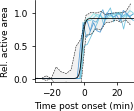

In [171]:
fig1, ax1 = plt.subplots(figsize=(2.2,1.8))
# fig1, ax1 = plt.subplots(figsize=(6,4))

xs = []
ys = []
for ci, correlation_data in enumerate(corr_data_structs):
    for roi in correlation_data["traces"].keys():
        t_offsets = np.array(correlation_data["t_offsets"][roi])
        corr_size = np.array(correlation_data["correlated_size"][roi])
        mean_corr = np.array(correlation_data["mean_corr"][roi])

        y = corr_size
        y[mean_corr < 0.65] = 0
        x = t_offsets/60
        y = y/np.percentile(y, 95)
        mask = np.ones_like(y, dtype=bool)
        mask[(x > 0) & (y == 0)] = False
        xs.append(x[mask])
        ys.append(y[mask])
#         ax1.scatter(np.array(x), y, alpha=0.2, s=2)
seed = 415515
np.random.seed(seed)
sample_traces = [13, 38, 10,  2,  6]
for i,tr in enumerate(sample_traces):
#     print(ys[tr])
    ax1.plot(xs[tr], ys[tr], color=newcmp(i/4))
    
ax1.set_ylim(-0.05, 1.2)
xs = np.concatenate(xs)
ys = np.concatenate(ys)
print(ys.shape)
print(xs.shape)
xs = xs[np.isfinite(ys)]
ys = ys[np.isfinite(ys)]
popt, _ = optimize.curve_fit(sigmoid, xs, ys)
print(popt)
chisq = np.sum((ys-sigmoid(xs, popt[0],popt[1],popt[2]))**2)/len(xs)
print(chisq)
x_fit = np.linspace(np.min(xs), np.max(xs), 100)
y_fit = sigmoid(x_fit, popt[0], popt[1],popt[2])
ax1.plot(x_fit, y_fit, color="k")
ax1.set_xlabel("Time post onset (min)")
ax1.set_ylabel("Rel. active area")

bin_size = 3
x_ticks = np.arange(np.min(xs), np.max(xs), step=bin_size)
nearest_bin = np.argmin(np.subtract.outer(xs, x_ticks)**2, axis=1)
x_binned = x_ticks[nearest_bin]

mean_value = []
std_value = []
for x in x_ticks:
    binned_values = ys[x_binned==x]
    mean_value.append(np.nanmean(binned_values))
    std_value.append(np.nanstd(binned_values))
mean_value = np.array(mean_value)
std_value = np.array(std_value)
ax1.fill_between(x_ticks, mean_value-std_value, mean_value+std_value, color="k", alpha=0.05, lw=0, edgecolor=None)
ax1.plot(x_ticks, mean_value-std_value,color="k", lw=0.5, linestyle="--")
ax1.plot(x_ticks, mean_value+std_value,color="k", lw=0.5, linestyle="--")

ax1.set_xlim((-30,30))
plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure2/area_transition.svg"))


[-5.24994013  0.12331106]
0.2757424291876624


Text(0, 0.5, 'Rel. active area')

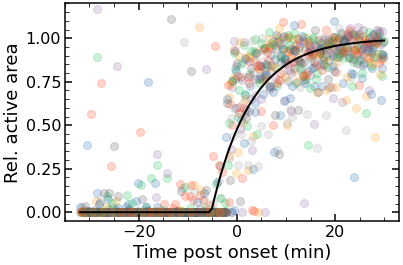

In [42]:
fig1, ax1 = plt.subplots(figsize=(6,4))
xs = []
ys = []
for ci, correlation_data in enumerate(corr_data_structs):
    for roi in correlation_data["correlated_size"].keys():
        t_offsets = np.array(correlation_data["t_offsets"][roi])
        corr_size = np.array(correlation_data["correlated_size"][roi])
        mask = np.ones(len(t_offsets), dtype=bool)
#         print(ci)
# #         print(roi)
#         if ci == 0 and roi == 0:
#             mask[6] = False
#         elif ci == 1 and roi == 

        x = t_offsets[mask]
        y = corr_size[mask]/np.percentile(corr_size[mask], 95)
        xs.append(x)
        ys.append(y)
        ax1.scatter(np.array(x)/60, y, alpha=0.2)
ax1.set_ylim(-0.05, 1.2)
xs = np.concatenate(xs)
ys = np.concatenate(ys)
popt, _ = optimize.curve_fit(custom_transition, xs/60, ys)
print(popt)
chisq = np.sum((ys-custom_transition(xs, popt[0],popt[1]))**2)/len(xs)
print(chisq)
x_fit = np.linspace(np.min(xs/60), np.max(xs/60), 100)
y_fit = custom_transition(x_fit, popt[0], popt[1])
ax1.plot(x_fit, y_fit, color="k", linewidth=2)
ax1.set_xlabel("Time post onset (min)")
ax1.set_ylabel("Rel. active area")

[0.31901444]
0.2761449973195118


Text(0, 0.5, 'Rel. active area')

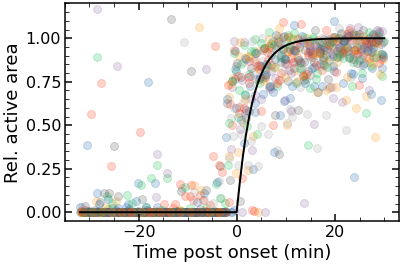

In [44]:
fig1, ax1 = plt.subplots(figsize=(6,4))
xs = []
ys = []
for ci, correlation_data in enumerate(corr_data_structs):
    for roi in correlation_data["correlated_size"].keys():
        t_offsets = np.array(correlation_data["t_offsets"][roi])
        corr_size = np.array(correlation_data["correlated_size"][roi])
        mask = np.ones(len(t_offsets), dtype=bool)
#         print(ci)
# #         print(roi)
#         if ci == 0 and roi == 0:
#             mask[6] = False
#         elif ci == 1 and roi == 

        x = t_offsets[mask]
        y = corr_size[mask]/np.percentile(corr_size[mask], 95)
        xs.append(x)
        ys.append(y)
        ax1.scatter(np.array(x)/60, y, alpha=0.2)
ax1.set_ylim(-0.05, 1.2)
xs = np.concatenate(xs)
ys = np.concatenate(ys)
popt, _ = optimize.curve_fit(custom_transition2, xs/60, ys)
print(popt)
chisq = np.sum((ys-custom_transition2(xs, popt[0]))**2)/len(xs)
print(chisq)
x_fit = np.linspace(np.min(xs/60), np.max(xs/60), 100)
y_fit = custom_transition2(x_fit, popt[0])
ax1.plot(x_fit, y_fit, color="k", linewidth=2)
ax1.set_xlabel("Time post onset (min)")
ax1.set_ylabel("Rel. active area")